##### Modelo SEIRS (Susceptibles, Expuestos, Infectados, Recuperados, Susceptibles)

In [1]:
import numpy as np
import scipy
import scipy.integrate

from utilidades import *

def seirs_model(SEIRS, beta, sigma, gamma, mu):
    S, E, I, R, F = SEIRS
    
    # Poblacion
    N = S + E + I + R
    
    dS = - beta * S * I / N
    dE = beta * S * I / N - sigma * E
    dI = sigma * E - gamma * I - mu * I
    dR = gamma * I
    dF = mu * I
    
    return [
        dS, dE, dI, dR, dF
    ]

Diferencias en los valores respecto a las razones de cambio:  
    * `beta` es la razon de transmision  
    * `sigma` es la razon de transicion de Expuesto a Infectado  
    * `gamma` es la razon de transicion de Infectado a Recuperado (o aislado)  
Nuevos parametros:  
    * `mu` es la razon de transicion de Infectado a Fallecido

In [2]:
periodo_incubacion = 5.2
periodo_infeccioso = 12.4
razon_mortalidad = 6 / 100.0

susceptibles_t0 = 11e6
infectados_t0 = 5

data = load_data()
days = [12, len(data[0]) - 12]

Infectados en tiempo 0: 8.53401495123564
R0: 3.6051371266991787
R1: 2.7858870610367714


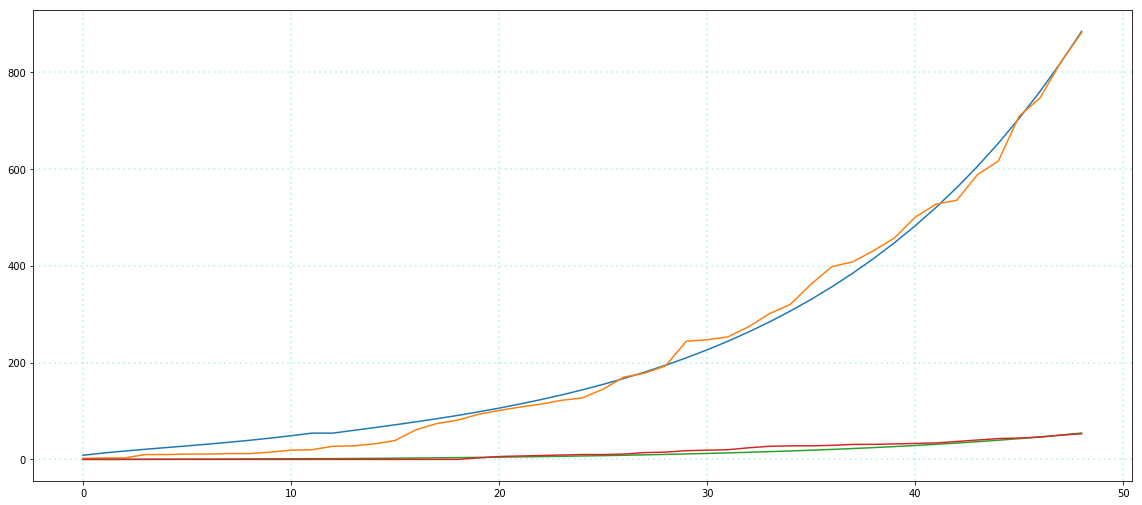

In [3]:
import scipy.optimize

def run_model(args):
    infectados_t0, R_t0, R_t1 = args
    
    SEIRS_t0 = (
        susceptibles_t0,
        infectados_t0 * R_t0,
        infectados_t0,
        0, 0
    )
    return run(
        seirs_model,
        SEIRS_t0,
        beta = [R0 / periodo_infeccioso for R0 in (R_t0, R_t1)],
        sigma = 1 / periodo_incubacion,
        gamma = 1 / periodo_infeccioso,
        mu = razon_mortalidad / periodo_infeccioso,
        days = days,
        step = 1
    )

def naive_fit():
    def sqsum(R_ts):
        solution = run_model(R_ts)
        return sum((solution['y'][2] - data[0]) ** 2)
    
    return scipy.optimize.minimize(
        sqsum, (5., 3., 3.), method='TNC', bounds=((1., 10.), (2.4, 4.2), (1.2, 3.2))
    ).x

R_ts_6 = naive_fit()
solution = run_model(R_ts_6)

plot(solution['t'], solution['y'][2], data[0], solution['y'][4], data[2])
print('Infectados en tiempo 0: {}\nR0: {}\nR1: {}'.format(*R_ts_6))

Para ajustar el modelo a los datos usamos una funcion que calcule la suma de las diferencias de los datos al cuadrado y buscamos los valores que minimicen esa diferencia.  
El numero de infectados iniciales para el modelo no tiene mucho sentido al ser real y no entero pero se trabaja con lo que se tiene

La razon de mortalidad reportada por varios paises varia entre el 1% y el 4% (algunos paises reportan una razon < 1%), como se comporta el modelo si ajustamos a la cantidad de fallecidos ajustando la razon a ese rango?

Mortalidad 1%
Infectados en tiempo 0: 50.0
R0: 4.2
R1: 2.3956960528820366


Mortalidad 4%
Infectados en tiempo 0: 27.348995508016156
R0: 3.114666040837245
R1: 2.111909588446355


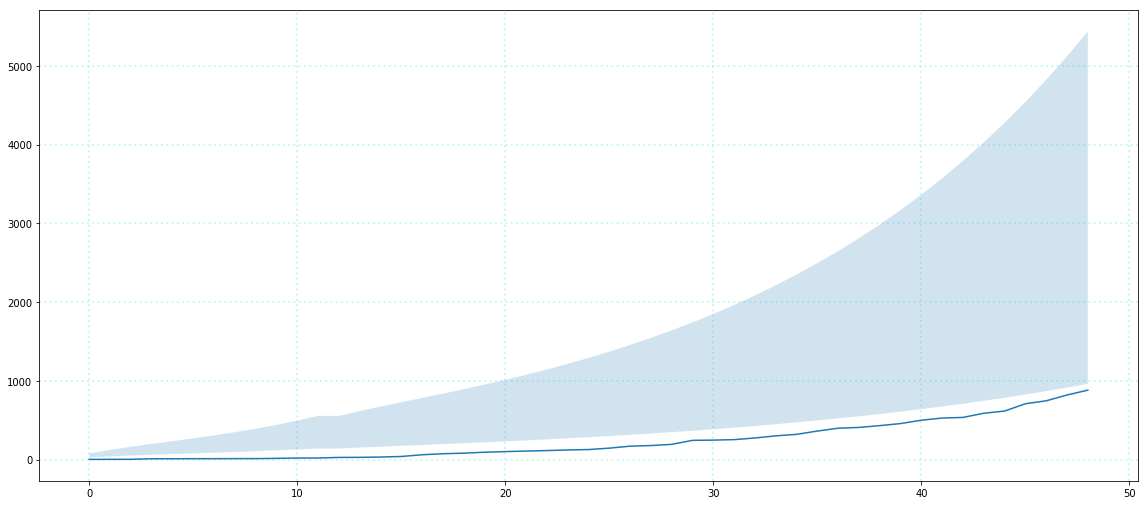

In [4]:
def naive_fit():
    def sqsum(R_ts):
        solution = run_model(R_ts)
        return sum((solution['y'][4] - data[2]) ** 2)
    
    return scipy.optimize.minimize(
        sqsum, (5., 3., 3.), method='TNC', bounds=((20., 50.), (2.4, 4.2), (1.2, 3.2))
    ).x

razon_mortalidad = 1 / 100.0
R_ts_1 = naive_fit()

razon_mortalidad = 4 / 100.0
R_ts_4 = naive_fit()

solution_1 = run_model(R_ts_1)
solution_4 = run_model(R_ts_4)

ax = plot(solution_4['t'], data[0])
ax.fill_between(
    solution_4['t'],
    solution_4['y'][2] + solution_1['y'][2],
    solution_4['y'][2],
    alpha=0.2
)

print('Mortalidad 1%\nInfectados en tiempo 0: {}\nR0: {}\nR1: {}\n\n'.format(*R_ts_1))
print('Mortalidad 4%\nInfectados en tiempo 0: {}\nR0: {}\nR1: {}'.format(*R_ts_4))

El rango maximo (fatalidad 1%) es algo irreal, ~ 30% de los fallecidos son de provincia y algunos no fueron diagnosticados hasta despues de fallecer.

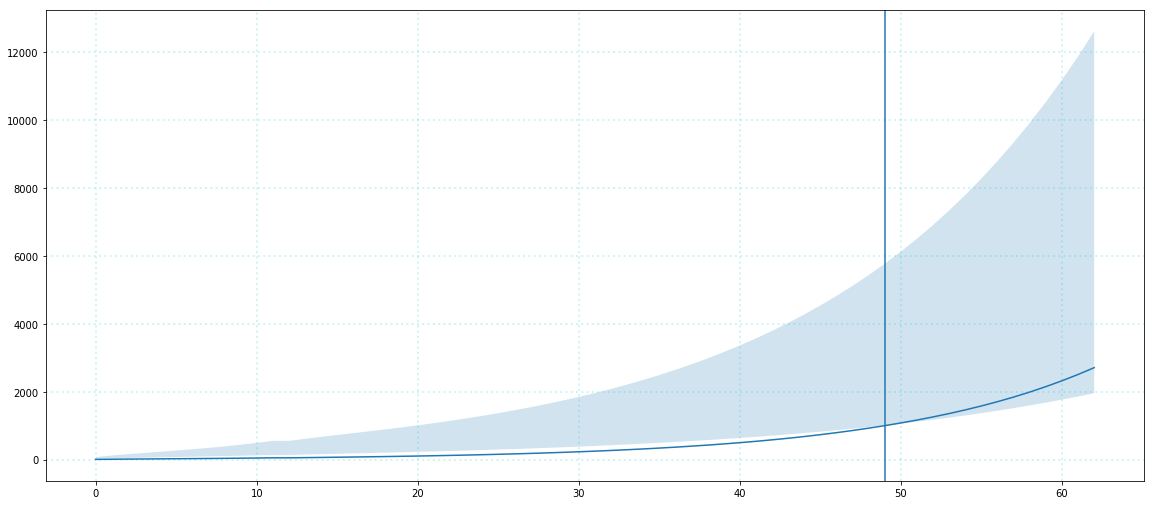

In [5]:
days[1] = len(data[0]) - days[0] + 14

solution_original = run_model(R_ts_6)
solution_1 = run_model(R_ts_1)
solution_4 = run_model(R_ts_4)

ax = plot(solution_original['t'], solution_original['y'][2])
ax.fill_between(
    solution_4['t'],
    solution_4['y'][2] + solution_1['y'][2],
    solution_4['y'][2],
    alpha=0.2
)
_ = ax.axvline(len(data[0]))

Proyeccion 14 dias, mucho puede cambiar y la sensibilidad a los datos iniciales es muy alta

Notas:
* Al ajustar la tasa de mortalidad al 4% asumiendo que hay varios infectados no detectados, el numero reproductivo a partir del comienzo de la cuarentena (03/22) `R1` es menor y a la larga proyecta menos casos.
* Sigue faltando fichar muchas de las cosas del primer notebook
    
Que hacer ahora?
* Agregar razon de deteccion, y razon de infeccion de casos detectados
* Hay datos sobre los tests hechos/dia, contactos? a hoy (03/28 21:00) <a href='https://www.worldometers.info/coronavirus/#countries'>worldometers</a> reporta 5,791 tests hechos y 1,014 detectados, la idea es ver como fue cambiando esa razon de deteccion por dia, cuan efectivo fue en los contactos de infectados, el cambio en la definicion de la enfermedad del ministro ayuda a ese cambio en la razon o es organica la cosa?